# Real-time optimization with Modifier Adapation using Gaussian Processes
## Preliminary results
A simple experiment was run to investigate the effect of the optimizer choice on the RTO convergence results. The following algorithms from the `scipy` package were evaluated:
- SLSQP: https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp
- Differentation evolution: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html

For the DE algorithm, it was considered the `best1bin` and `rand1bin` strategies, population size of 20 individuals and a maximum of 50 generations. The `polish` option was deactivated, so the results are only from the stochastic algorithm.

For each rto cycle consisting of 120 iterations, the process starts at a random feasible operating point around `u = [10.6521, 0.0005141, 224.4806]`, where 5 random operating points are also chosen for initialization of the Gaussian Process estimator. A gaussian noise of `0.01%` was added to the plant measurements. This was executed 20 times for each optimization algorithm evaluated. 



In [1]:
# First, let's import some necessary stuff
%load_ext autoreload
%autoreload 2

import matplotlib.font_manager
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#plt.style.use('ggplot')
#plt.style.use('seaborn-paper')
plt.rc('font', family='serif', serif='Times')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

# add the parent folder to path
lib_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(lib_path)

from bussineslogic.rto_data import RTODataModel
from optimization.utils import build_F, convert_ivp_results
from model.process.semi_batch import SemiBatchReactor

md_exact_slsqp = RTODataModel('/mnt/d/rto_data/rto_poc_sqp_experiments.db')
md_debest = RTODataModel('/mnt/d/rto_data/rto_poc_de_experiments.db')

# The real plant optimum
# Load the real model to generate samples
model_ideal = SemiBatchReactor()
u_plant = [18.4427644, 0.00110823777, 227.792418]
f_plant = -0.5085930760109818


## Data Preparation

In [2]:
# Now, let's load the results data
# Then load the results
all_results_exact_klast = pd.DataFrame(md_exact_slsqp.get_rto_experiment_results('ma-gp-slsqp_scipy-k_last-0.01-0.0'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id', 'run.status', 'iteration', 'var_name', 'value'])
all_results_debest1bin_klast = pd.DataFrame(md_debest.get_rto_experiment_results('ma-gp-de_scipy_best1bin-k_last-0.01-0.0'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id', 'run.status', 'iteration', 'var_name', 'value'])
all_results_exact_klast_noisy = pd.DataFrame(md_exact_slsqp.get_rto_experiment_results('ma-gp-slsqp_scipy-k_last-0.05-0.0'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id', 'run.status', 'iteration', 'var_name', 'value'])
all_results_debest1bin_klast_noisy = pd.DataFrame(md_debest.get_rto_experiment_results('ma-gp-de_scipy_best1bin-k_last-0.05-0.0'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id', 'run.status', 'iteration', 'var_name', 'value'])


In [3]:
# After that, preprocess the DB data
def aggfunc(x):
    return x
# Define a helper function to perform the calculations
def pre_process_results(all_results):
    # Transform the data
    all_results_pv = pd.pivot_table(all_results, values='value', index=['run.id','iteration','rto.type','run.status'], columns=['var_name'], aggfunc=aggfunc)
    all_results_pv.reset_index(level=all_results_pv.index.names, inplace=True)
    
    # remove the suffix
    all_results_pv['rto.type'] = all_results_pv['rto.type'].apply(lambda x: x.split('-')[2])

    # Convert the values
    all_results_pv[['cost_model','cost_real','fobj_modifier']] = all_results_pv[['cost_model','cost_real','fobj_modifier']].astype('float')

    # Extract some variables
    all_results_pv['g_0'] = all_results_pv['g_real'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1'] = all_results_pv['g_real'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['g_0_model'] = all_results_pv['g_model'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1_model'] = all_results_pv['g_model'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['g_0_modifiers'] = all_results_pv['g_modifiers'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1_modifiers'] = all_results_pv['g_modifiers'].apply(lambda x: float(x.split(',')[1])) 

    all_results_pv['tm'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['Fs'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['ts'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[2])) 

    # kpis
    all_results_pv['du'] = all_results_pv[['tm','Fs','ts']].apply(lambda x: np.linalg.norm(100 * (x - u_plant)/u_plant), axis=1)
    all_results_pv['dPhi'] = all_results_pv[['cost_real']].apply(lambda x: 100 * np.abs((x - f_plant)/f_plant))
    all_results_pv['g_Cb_tf'] = all_results_pv['g_0'].apply(lambda x: 'Not violated' if x <= 0.025 else 'Violated')
    all_results_pv['g_Cd_tf'] = all_results_pv['g_1'].apply(lambda x: 'Not violated' if x <= 0.15 else 'Violated')


    return all_results_pv

In [4]:
# Now apply the transformation
results_exact_klast = pre_process_results(all_results_exact_klast)
results_best1bin_klast = pre_process_results(all_results_debest1bin_klast)
results_exact_klast_noisy = pre_process_results(all_results_exact_klast_noisy)
results_best1bin_klast_noisy = pre_process_results(all_results_debest1bin_klast_noisy)

# Join the as a single dataframe
results_all = pd.concat([results_exact_klast, results_best1bin_klast], ignore_index=True)
results_all_noisy = pd.concat([results_exact_klast_noisy, results_best1bin_klast_noisy], ignore_index=True)

## Results

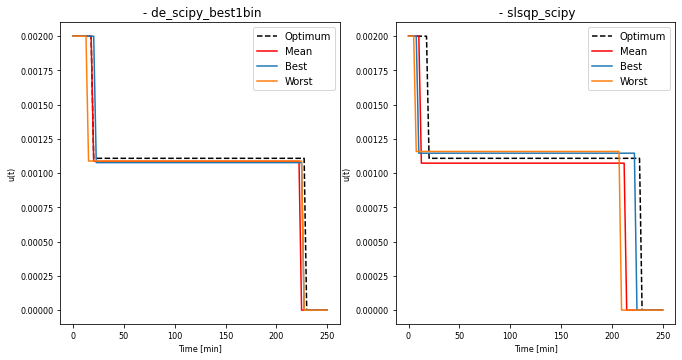

In [13]:
# helper function for plotting
def plot_results(data, y, ylabel, title='', x='iteration', hue='rto.type', style='run.status', estimator=np.mean, ci=95, save=False, err_style='band'):
    width = 3.487
    height = width / 1.618
    
    if ci == 'range':
        data_grouped = data.groupby(hue)
        fig, ax = plt.subplots(1, len(data_grouped.groups), figsize=(15.1667, 5.1667))
        i = 0
        for name, group in data_grouped:
            group_agg = group.groupby(x)[y]
            error = [group_agg.mean() - group_agg.min(), group_agg.max() - group_agg.mean()]
            ax[i].errorbar(list(group_agg.groups.keys()), group_agg.mean(), yerr=error, fmt='o')
            ax[i].set_xlabel('Iteration')
            ax[i].set_ylabel(ylabel)
            i = i + 1
    else:
        fig, ax = plt.subplots(figsize=(5.1667, 5.1667))
        #fig, ax = plt.subplots(figsize=(width, height))
        fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
        sns.lineplot(data=data, y=y, x=x, hue=hue, style=style, ax=ax, estimator=estimator, ci=ci, err_style=err_style, seed=1234)
        ax.set_xlabel('Iteration')
        ax.set_ylabel(ylabel)
        ax.set_title(title)

    if save == True:
        fig.savefig('fig_{}.pdf'.format(y), dpi=300)

    return ax, fig

def plot_last_input_signal(data, ylabel = 'u(t)', y = ['tm','Fs','ts'], hue='rto.type', title=''):
    data_last_iteration = data[data['iteration'] == max(data['iteration'])]
    data_grouped = data_last_iteration.groupby(hue)

    fig, ax = plt.subplots(figsize=(5.1667, 5.1667))    
    fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
    # Opt results
    sim_opt = model_ideal.simulate(u_plant)    
    F_opt = build_F(sim_opt.t, u_plant)

    ax.plot(sim_opt.t, F_opt, 'k--')

    for name, group in data_grouped:
        u_mean = group[y].mean()
        # Build the input signal F
        F_mean = build_F(sim_opt.t, u_mean)
        # Plot the input signal
        ax.plot(sim_opt.t, F_mean)
        #ax.legend(name)

    ax.set_xlabel('Time [min]')
    ax.set_ylabel(ylabel)    
    ax.set_title(title)
    ax.legend(['Optimum'] + list(data_grouped.groups.keys()))

def plot_last_input_signal_range(data, ylabel = 'u(t)', y = ['tm','Fs','ts'], hue='rto.type', title=''):
    data_last_iteration = data[data['iteration'] == max(data['iteration'])]
    data_grouped = data_last_iteration.groupby(hue)

    fig, ax = plt.subplots(1, len(data_grouped.groups), figsize=(10.1667, 5.1667))    
    fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
    # Opt results
    sim_opt = model_ideal.simulate(u_plant)    
    F_opt = build_F(sim_opt.t, u_plant)

    i = 0
    for name, group in data_grouped:
        ax[i].plot(sim_opt.t, F_opt, 'k--')
        # find max cost index
        i_min = np.argmin(group[(group['g_Cb_tf'] == 'Not violated') & (group['g_Cd_tf'] == 'Not violated')]['cost_real'])
        i_max = np.argmax(group[(group['g_Cb_tf'] == 'Not violated') & (group['g_Cd_tf'] == 'Not violated')]['cost_real'])
        
        u_mean = group[y].mean()
        u_min =  group[y].iloc[i_min,:]
        u_max =  group[y].iloc[i_max,:]
        
        # Build the input signal F
        F_mean = build_F(sim_opt.t, u_mean)
        F_min = build_F(sim_opt.t, u_min)
        F_max = build_F(sim_opt.t, u_max)

        # Plot the input signal
        ax[i].plot(sim_opt.t, F_mean, 'r')
        ax[i].plot(sim_opt.t, F_min)
        ax[i].plot(sim_opt.t, F_max)

        ax[i].set_xlabel('Time [min]')
        ax[i].set_ylabel(ylabel)    
        ax[i].set_title(title + ' - ' + name)
        #ax[i].legend(['Optimum', f"Mean: {group['cost_real'].mean()}", f"Best: {group['cost_real'].min()}", f"Worst: {group['cost_real'].max()}"])
        ax[i].legend(['Optimum', "Mean", "Best", "Worst"])

        i = i + 1

plot_last_input_signal_range(results_all)



findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


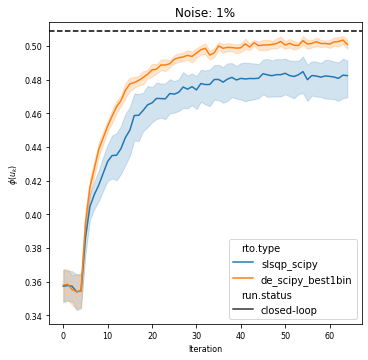

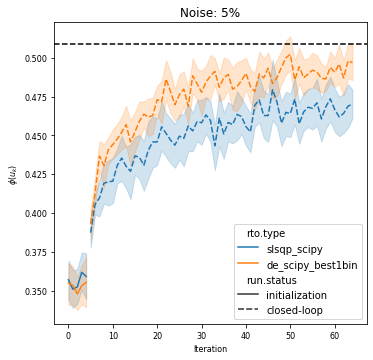

In [6]:
# Plot the convergence results for objective function
neg_mean = lambda x: -np.mean(x)

ax, fig = plot_results(results_all, 'cost_real', '$\phi(u_k)$', estimator=neg_mean, title='Noise: 1%')
ax.axhline(-f_plant, linestyle='--', color='k')
fig.show()

ax, fig = plot_results(results_all_noisy, 'cost_real', '$\phi(u_k)$', estimator=neg_mean,  title='Noise: 5%')
ax.axhline(-f_plant, linestyle='--', color='k')
fig.show()

    

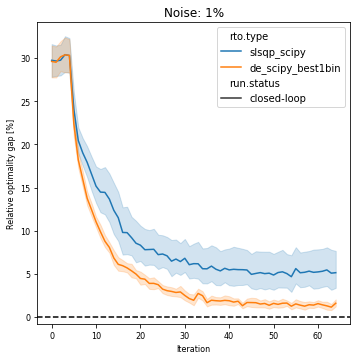

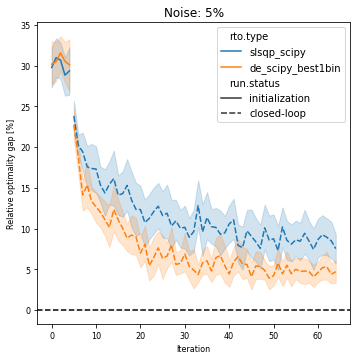

In [7]:
# Plot the convergence results for dPhi
ax, fig = plot_results(results_all, 'dPhi', 'Relative optimality gap [%]', title='Noise: 1%')
ax.axhline(0, linestyle='--', color='k')
fig.show()

ax, fig = plot_results(results_all_noisy, 'dPhi', 'Relative optimality gap [%]', title='Noise: 5%')
ax.axhline(0, linestyle='--', color='k')
fig.show()



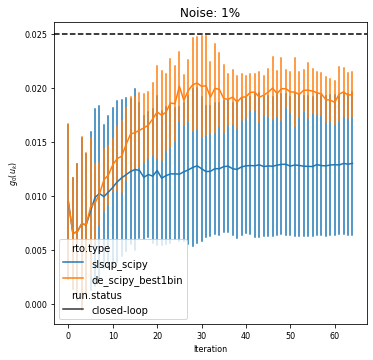

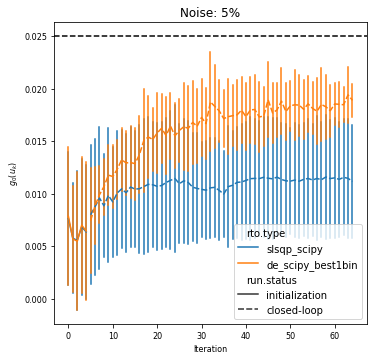

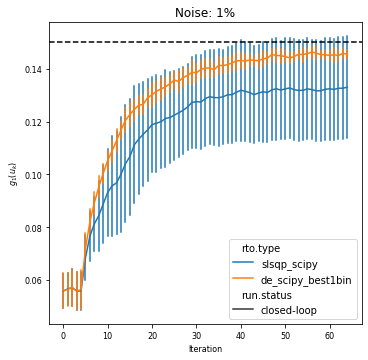

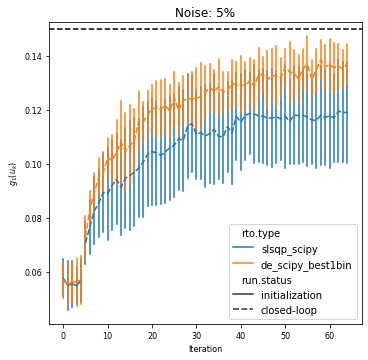

In [8]:
# Plot the convergence results for constraints
# g0
ax, fig = plot_results(results_all, 'g_0', '$g_0(u_k)$', ci='sd', err_style='bars', title='Noise: 1%')
ax.axhline(0.025, linestyle='--', color='k')
fig.show()

ax, fig = plot_results(results_all_noisy, 'g_0', '$g_0(u_k)$', ci='sd', err_style='bars', title='Noise: 5%')
ax.axhline(0.025, linestyle='--', color='k')
fig.show()

# g1
ax, fig = plot_results(results_all, 'g_1', '$g_1(u_k)$', ci='sd', err_style='bars', title='Noise: 1%')
ax.axhline(0.15, linestyle='--', color='k')
fig.show()

# g1
ax, fig = plot_results(results_all_noisy, 'g_1', '$g_1(u_k)$', ci='sd', err_style='bars', title='Noise: 5%')
ax.axhline(0.15, linestyle='--', color='k')
fig.show()


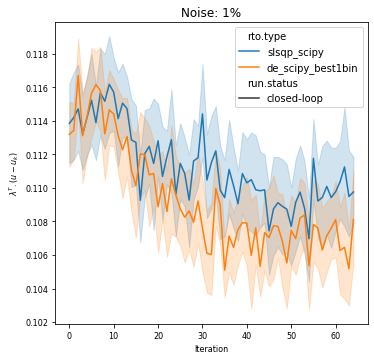

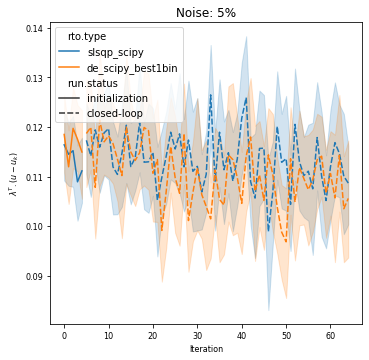

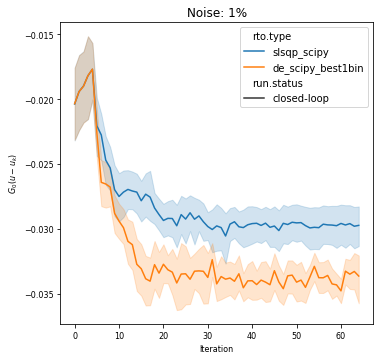

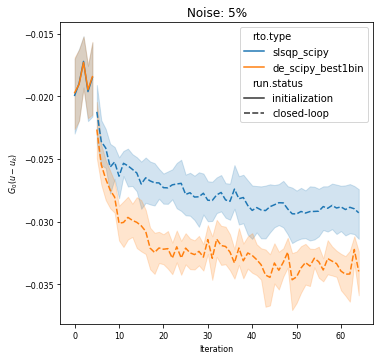

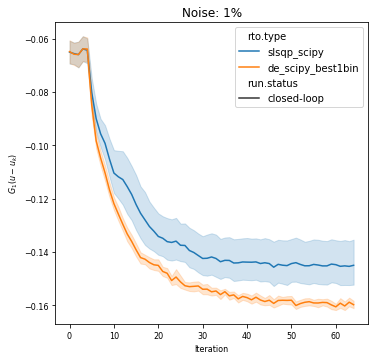

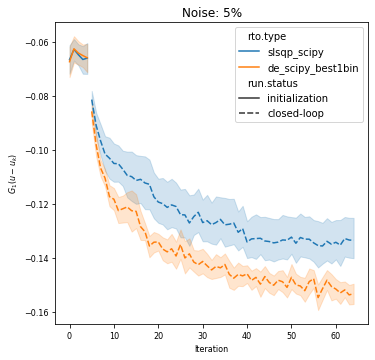

In [9]:
# Plot the cost modifier estimation
ax, fig = plot_results(results_all, 'fobj_modifier', '$\lambda^T . (u - u_k)$',title='Noise: 1%')
fig.show()
ax, fig = plot_results(results_all_noisy, 'fobj_modifier', '$\lambda^T . (u - u_k)$',title='Noise: 5%')
fig.show()


ax, fig = plot_results(results_all, 'g_0_modifiers', '$G_0(u - u_k)$',title='Noise: 1%')
fig.show()
ax, fig = plot_results(results_all_noisy, 'g_0_modifiers', '$G_0(u - u_k)$',title='Noise: 5%')
fig.show()


ax, fig = plot_results(results_all, 'g_1_modifiers', '$G_1(u - u_k)$', title='Noise: 1%')
fig.show()
ax, fig = plot_results(results_all_noisy, 'g_1_modifiers', '$G_1(u - u_k)$', title='Noise: 5%')
fig.show()

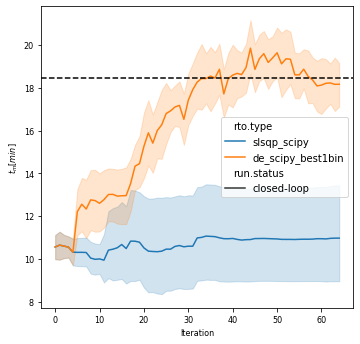

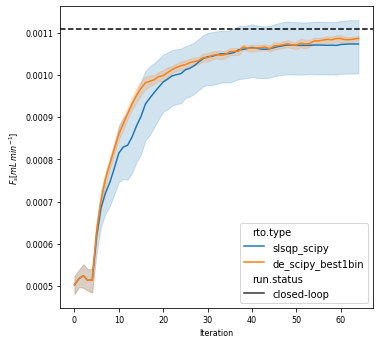

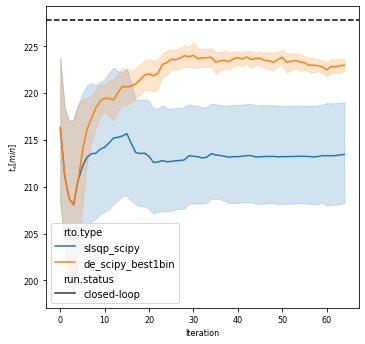

In [10]:
# Plot the convergence results for the input signal
ax, fig = plot_results(results_all, 'tm', '$t_m [min]$')
ax.axhline(u_plant[0], linestyle='--', color='k')
fig.show()

ax, fig = plot_results(results_all, 'Fs', '$F_s [mL \: min^{-1}]$')
ax.axhline(u_plant[1], linestyle='--', color='k')
fig.show()

ax, fig = plot_results(results_all, 'ts', '$t_s [min]$')
ax.axhline(u_plant[2], linestyle='--', color='k')
fig.show()


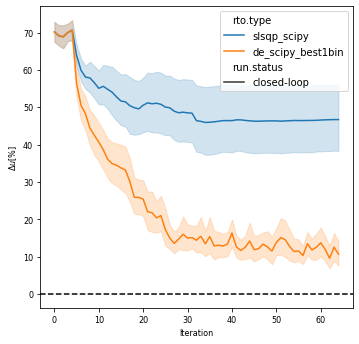

In [11]:
# Plot the convergence results for the input signal difference
ax, fig = plot_results(results_all, 'du', '$\Delta u [\%] $')
ax.axhline(0, linestyle='--', color='k')
fig.show()

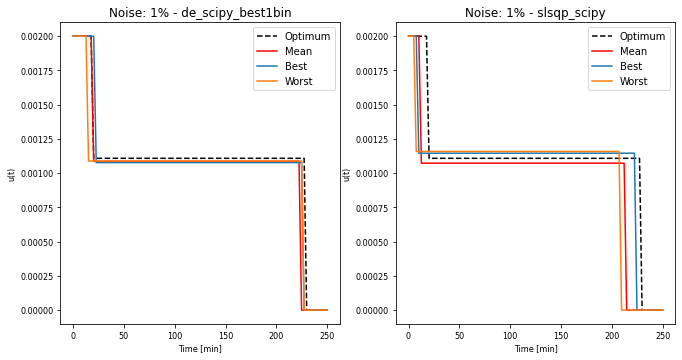

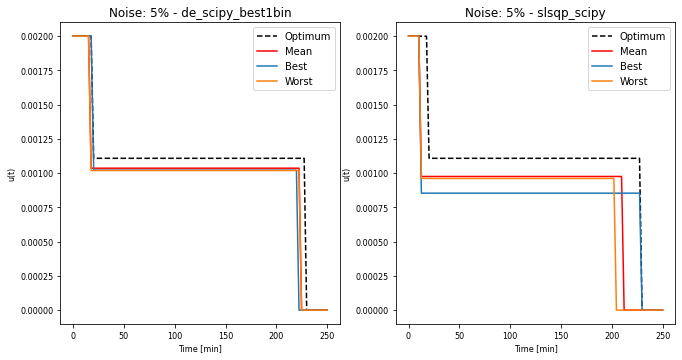

In [14]:
# Plot the last iteration found output signal
# Considering the last iteration, it plots the input signal u(t) for the best, average and worst plant cost value.
# The real optimum is the black dashed-line
plot_last_input_signal_range(results_all, title='Noise: 1%')
plot_last_input_signal_range(results_all_noisy, title='Noise: 5%')